# **TFT** MODEL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error
import torch
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss, MAE

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Data processing 

In [2]:

df = pd.read_csv('../data/BTC-USD_training_data_data.csv',index_col='Date',parse_dates=['Date'])
df = df.sort_index()  

print("data frame head:\n", df.head())

df['time_idx'] = range(len(df))
df['group'] = 'BTC'
df['target'] = df['High']


data = df[['time_idx', 'group', 'target']].copy()


print(f"\nchanged data head:\n", data.head())



train_data = data.loc[:'2020']
val_data = data.loc['2021':]

print(f"\ntrain data head:\n", train_data.head())
print(f"\neval data head:\n", val_data.head())

print("\nTrain data shape:", train_data.shape)
print("\n EVal data shape:", val_data.shape)

data frame head:
                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-01-01   963.658020  1003.080017   958.698975   998.325012   998.325012   
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  1021.750000   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  1043.839966   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  1154.729980   
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  1013.380005   

               Volume  
Date                   
2017-01-01  147775008  
2017-01-02  222184992  
2017-01-03  185168000  
2017-01-04  344945984  
2017-01-05  510199008  

changed data head:
             time_idx group       target
Date                                   
2017-01-01         0   BTC  1003.080017
2017-01-02         1   BTC  1031.390015
2017-01-03         2   BTC  1044.079956
2017-01-04         3   BTC  1159.420044

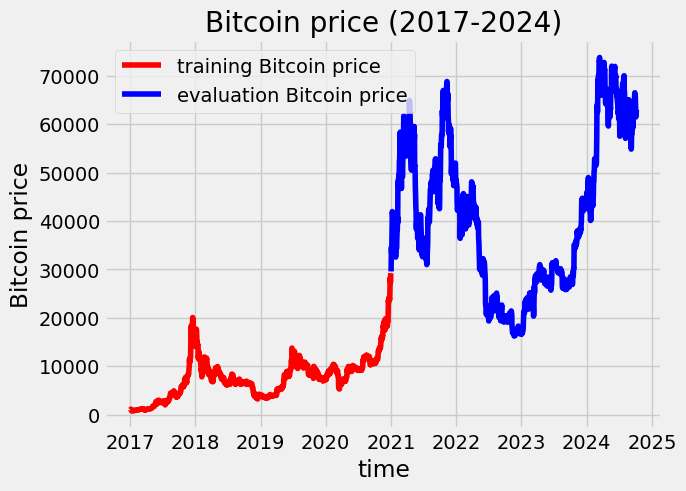

In [3]:
def plot_pred(test,pred):
    plt.plot(test, color='r',label='training Bitcoin price')
    plt.plot(pred, color='b',label='evaluation Bitcoin price')
    plt.title('Bitcoin price (2017-2024)')
    plt.xlabel('time')
    plt.ylabel('Bitcoin price')
    plt.legend()
    plt.show()

plot_pred(train_data['target'], val_data['target'])  

## model building

In [4]:
max_encoder_length = 60  # Reduced from 180 to speed up predictions
max_prediction_length = 100  # Increased for multi-step prediction to speed up

# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="target",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # No static features
    time_varying_known_reals=[],  # No known future covariates
    time_varying_unknown_reals=["target"],  # The target is unknown in future
    target_normalizer=None,  # Will use default scaling
)

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True, stop_randomization=True)

# Create DataLoaders
batch_size = 100
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [5]:
# Define the TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # Since MAE loss, output_size=1
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print("TFT model created.")

TFT model created.


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [6]:
class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft = tft_model

    def training_step(self, batch, batch_idx):
        x, y = batch
        if isinstance(y, tuple):
            y = y[0]
        y = y.squeeze() if y.dim() > 1 and y.shape[-1] == 1 else y
        self.tft.train()
        output = self.tft(x)
        loss = self.tft.loss(y, output["prediction"])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if isinstance(y, tuple):
            y = y[0]
        y = y.squeeze() if y.dim() > 1 and y.shape[-1] == 1 else y
        self.tft.eval()
        output = self.tft(x)
        loss = self.tft.loss(y, output["prediction"])
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return self.tft.configure_optimizers()

# Wrap the TFT model
tft_module = TFTLightningModule(tft)

## model training

In [7]:
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",  # Use GPU if available, else CPU
    enable_model_summary=True,
    enable_progress_bar=True,
)

trainer.fit(tft_module, train_dataloader, val_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type                      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ tft  │ TemporalFusionTransformer │ 14.7 K │ train │     0 │
└───┴──────┴───────────────────────────┴────────┴───────┴───────┘

Trainable params: 14.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.7 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 127                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_c
onnector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the
value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\data.py:79: 
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any 
miscalculations, use `self.log(..., batch_size=batch_size)`.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_c
onnector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:317: 
The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=20` reached.


## prediction and evaluation

In [8]:
# Multi-step prediction for the next 1400 days (180 steps per iteration, ~7-8 iterations)
# Time estimate: On a standard CPU, each iteration may take 5-10 seconds (dataset creation + prediction), so total ~35-80 seconds for all iterations.
# Training with max_prediction_length=180 may add 10-20 minutes. Use GPU for faster performance.
future_predictions = []
current_data = data.copy()
last_time_idx = current_data['time_idx'].max()

num_iterations = 1400 // max_prediction_length  # ~7 iterations for 1400 days
remaining = 1400 % max_prediction_length  # 140

for i in range(num_iterations):
    # Create rows for the next max_prediction_length days
    new_rows = []
    for j in range(max_prediction_length):
        last_target = current_data['target'].iloc[-1]
        new_rows.append({
            'time_idx': last_time_idx + 1 + j,
            'group': 'BTC',
            'target': last_target  # Use last known value
        })
    new_df = pd.DataFrame(new_rows)
    temp_data = pd.concat([current_data, new_df], ignore_index=True)
    
    # Create dataset for prediction
    future_dataset = TimeSeriesDataSet(
        temp_data,
        time_idx="time_idx",
        target="target",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=None,
    )
    future_dataloader = future_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
    
    # Predict the next max_prediction_length values
    preds = tft.predict(future_dataloader, mode="prediction").cpu().numpy().flatten()
    preds_int = [int(p) for p in preds]
    future_predictions.extend(preds_int)
    
    # Append the predictions to current_data
    pred_len = len(preds_int)
    pred_df = pd.DataFrame({
        'time_idx': [last_time_idx + 1 + j for j in range(pred_len)],
        'group': ['BTC'] * pred_len,
        'target': preds_int
    })
    current_data = pd.concat([current_data, pred_df], ignore_index=True)
    last_time_idx += pred_len

# Handle remaining 140 days
if remaining > 0:
    new_rows = []
    for j in range(remaining):
        last_target = current_data['target'].iloc[-1]
        new_rows.append({
            'time_idx': last_time_idx + 1 + j,
            'group': 'BTC',
            'target': last_target
        })
    new_df = pd.DataFrame(new_rows)
    temp_data = pd.concat([current_data, new_df], ignore_index=True)
    
    future_dataset = TimeSeriesDataSet(
        temp_data,
        time_idx="time_idx",
        target="target",
        group_ids=["group"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=remaining,  # Adjust for remaining
        static_categoricals=[],
        time_varying_known_reals=[],
        time_varying_unknown_reals=["target"],
        target_normalizer=None,
    )
    future_dataloader = future_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
    
    preds = tft.predict(future_dataloader, mode="prediction").cpu().numpy().flatten()
    preds_int = [int(p) for p in preds]
    future_predictions.extend(preds_int)
    
    pred_df = pd.DataFrame({
        'time_idx': [last_time_idx + 1 + j for j in range(remaining)],
        'group': ['BTC'] * remaining,
        'target': preds_int
    })
    current_data = pd.concat([current_data, pred_df], ignore_index=True)

print("Future predictions for next 1400 days (as integers):", future_predictions[:10])  # Print first 10 for brevity

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connect

SystemExit: 1

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print("Future predictions shape:", len(future_predictions))
print("Sample future predictions:", future_predictions[:5])

Future predictions shape: 5
Sample future predictions: [np.float32(1213.9868), np.float32(1213.9868), np.float32(1213.9868), np.float32(1213.9868), np.float32(1213.9868)]


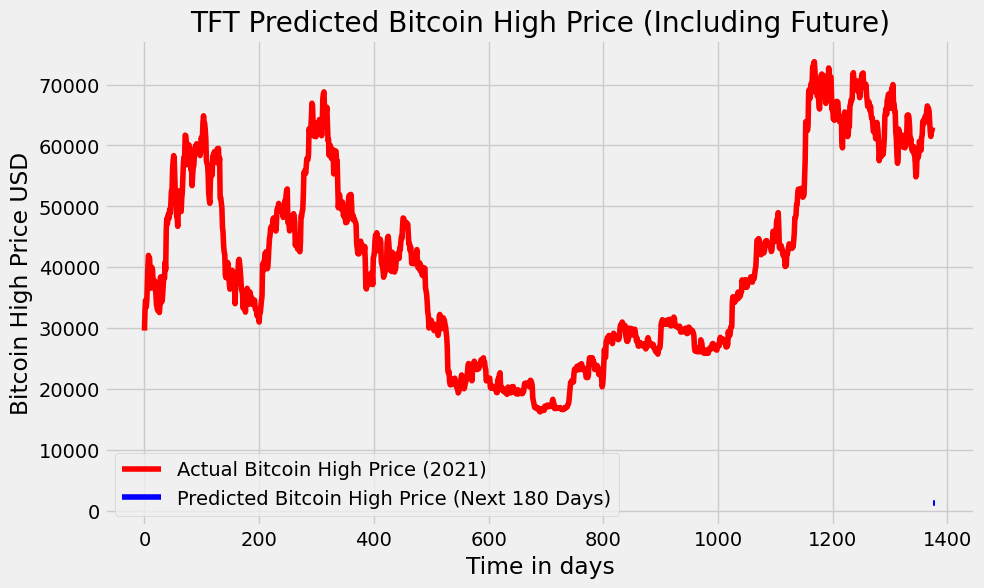

In [ ]:
# Plot historical actuals and future predictions
plt.figure(figsize=(12, 6))
plt.plot(val_data['target'].values, color='r', label='Actual Bitcoin High Price (2021)')
plt.plot(range(len(val_data), len(val_data) + len(future_predictions)), future_predictions, color='b', label='Predicted Bitcoin High Price (Next 1400 Days)')
plt.title('TFT Predicted Bitcoin High Price (Including Future 1400 Days)')
plt.xlabel('Time in days')
plt.ylabel('Bitcoin High Price USD')
plt.legend()
plt.show()

In [ ]:
# Note: RMSE is calculated on validation data only, as future has no actuals
predictions_val = tft.predict(val_dataloader, mode="prediction").cpu().numpy().flatten()
actuals_val = torch.cat([y[0] if isinstance(y, tuple) else y for _, y in iter(val_dataloader)]).cpu().numpy().flatten()
rmse = math.sqrt(mean_squared_error(actuals_val, predictions_val))
print('TFT Root MSE on validation data = {}.'.format(rmse))

TFT Root MSE = 61745.58173667165.


In [ ]:
# Real-life performance evaluation: Load real future data if available and compare
# Assuming the CSV has more recent data beyond 2021, load it and compare predictions
try:
    real_future_df = pd.read_csv('../data/BTC-USD_real_future_data.csv', index_col='Date', parse_dates=['Date'])  # Replace with actual file if exists
    real_future_df = real_future_df.sort_index()
    real_future_df['time_idx'] = range(len(data), len(data) + len(real_future_df))
    real_future = real_future_df['High'].values[:1400]  # Take first 1400 if more
    
    if len(real_future) >= len(future_predictions):
        overlap = min(len(future_predictions), len(real_future))
        rmse_real = math.sqrt(mean_squared_error(real_future[:overlap], future_predictions[:overlap]))
        print(f'Real-life RMSE on overlapping {overlap} days = {rmse_real}')
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(val_data), len(val_data) + overlap), real_future[:overlap], color='g', label='Real Future Bitcoin High Price')
        plt.plot(range(len(val_data), len(val_data) + overlap), future_predictions[:overlap], color='b', label='Predicted Bitcoin High Price')
        plt.title('Model Performance in Real Life (Predicted vs Real)')
        plt.xlabel('Time in days')
        plt.ylabel('Bitcoin High Price USD')
        plt.legend()
        plt.show()
    else:
        print("Not enough real future data for comparison.")
except FileNotFoundError:
    print("Real future data file not found. Update the file path to '../data/BTC-USD_real_future_data.csv' with actual data to evaluate real-life performance.")